### Βήμα 3: Classification δεδομένων

#### Βιβλιοθήκες

In [206]:
from operator import index

import numpy as np
import pandas as pd
import seaborn as sns
from keras.src.saving.legacy.saved_model.load import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

#### Φόρτωση δεδομένων

In [207]:
bank_data = pd.read_csv('../data_preprocessing/clean_data.csv')
# Get rid of unwanted extra column
bank_data.drop('Unnamed: 0', axis=1, inplace=True)

### 1ος Ταξινομητής: Bayesian

#### Encoding κατηγορικών χαρακτηριστικών

In [208]:
bank_data, bank_data_label = pd.get_dummies(bank_data.drop('y', axis=1)), bank_data.y

#### Διαχωρισμός εξαρτημένων(y) και ανεξάρτηων μεταβλητών

In [209]:
X = bank_data
y = bank_data_label

#### Split

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True, stratify=y)

#### Κανονικοποίηση

In [211]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Εκπαίδευση του Bayesian ταξινομητή

In [212]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

### Αξιολόγηση ταξινομητή

#### Accuracy Score

In [213]:
y_prediction = classifier.predict(X_test)

In [214]:
accuracy_score(y_test, y_prediction)

0.8803982415309025

#### Classification Report

In [215]:
print(f'Classification Report: \n{classification_report(y_test, y_prediction)}')

Classification Report: 
              precision    recall  f1-score   support

       False       0.94      0.93      0.93      7057
        True       0.34      0.39      0.37       677

    accuracy                           0.88      7734
   macro avg       0.64      0.66      0.65      7734
weighted avg       0.89      0.88      0.88      7734



#### Confusion Matrix

<Axes: >

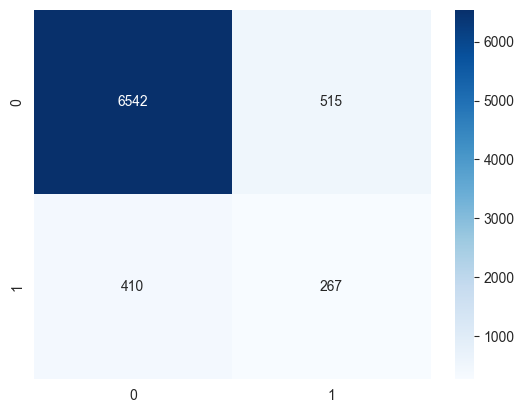

In [216]:
cf_matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)

#### AUC/ROC curve

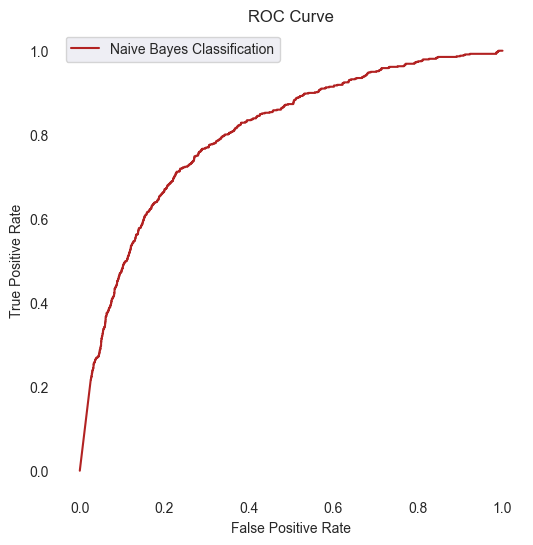

In [217]:
# Plot AUC/ROC curve
y_pred_proba = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label='Naive Bayes Classification', color = 'firebrick')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.box(False)
ax.legend();

### 2ος Ταξινομητής: XGBoost

#### Διαχωρισμός ανεξάρτητων και εξαρτημένων μεταβλητών, split

In [218]:
X_train_full_xgb = X_train
X_test_xgb = X_test
y_train_full_xgb = y_train
y_test_xgb = y_test

# Making validation sets
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train_full_xgb, y_train_full_xgb, test_size=0.2, random_state=42, stratify=y_train_full_xgb) 

#### Εκπαίδευση του ταξινομητή

In [219]:
xgboost_classifier = XGBClassifier(n_estimators=25,n_jobs=-1, early_stopping_rounds=10)
xgboost_classifier.fit(X_train_xgb, y_train_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

### Αξιολόγηση του ταξινομητή

In [220]:
xgboost_classifier.score(X_test_xgb, y_test_xgb)

0.9226790793897078

#### Confusion matrix

<Axes: >

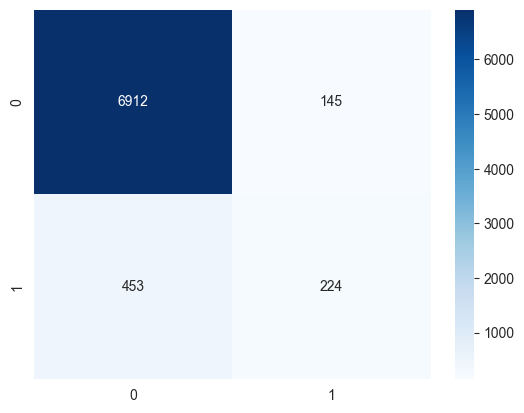

In [221]:
cf_matrix = confusion_matrix(y_test_xgb, xgboost_classifier.predict(X_test_xgb))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)

#### Classification report

In [222]:
print(classification_report(y_test_xgb, xgboost_classifier.predict(X_test_xgb)))

              precision    recall  f1-score   support

       False       0.94      0.98      0.96      7057
        True       0.61      0.33      0.43       677

    accuracy                           0.92      7734
   macro avg       0.77      0.66      0.69      7734
weighted avg       0.91      0.92      0.91      7734



#### AUC/ROC curve

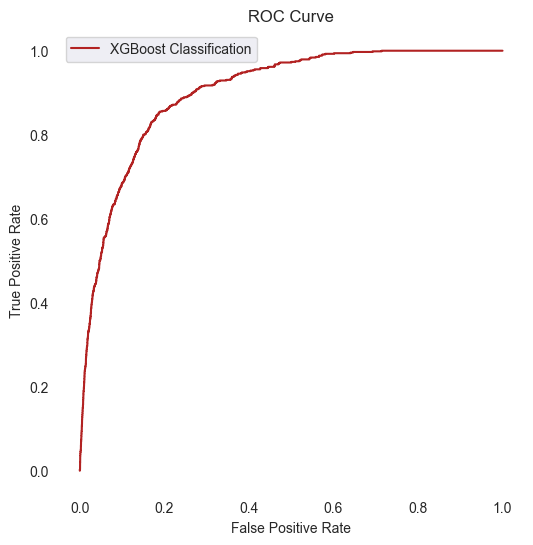

In [223]:
# Plot AUC/ROC curve
y_pred_proba_xgb = xgboost_classifier.predict_proba(X_test_xgb)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_xgb,  y_pred_proba_xgb)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label='XGBoost Classification', color = 'firebrick')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.box(False)
ax.legend();

#### Feature Importance

In [224]:
feature_importances = xgboost_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(importance_df)

                Feature  Importance
3               housing    0.127789
26            month_apr    0.068465
33            month_mar    0.066416
34            month_may    0.058788
5              duration    0.057690
7                 pdays    0.047211
4                  loan    0.045301
37            month_sep    0.042788
36            month_oct    0.041886
35            month_nov    0.033486
23    education_primary    0.026408
28            month_dec    0.024566
19       job_unemployed    0.023058
27            month_aug    0.021746
17          job_student    0.020848
31            month_jul    0.020705
30            month_jan    0.020254
32            month_jun    0.018540
0                   age    0.016948
25   education_tertiary    0.016136
6              campaign    0.015081
21      marital_married    0.014461
10      job_blue-collar    0.014217
29            month_feb    0.014148
2               balance    0.013571
15    job_self-employed    0.013365
1               default    0

---

## Νευρωνικά δίκτυα με tensorflow/keras

### Model1 - Standard Training

#### Θα χρησιμποιηθούν τα sets όπως μετασχηματίστηκαν για τον Bayesian ταξινομητή

In [225]:
X_train_nw = X_train
X_test_nw = X_test
y_train_nw = y_train
y_test_nw = y_test

#### Model1 Initialization & Compilation

In [226]:
model1 = Sequential([
    Input(shape=(X_train_nw.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [227]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [228]:
model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                2496      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model1 Training

In [229]:
history = model1.fit(X_train_nw, y_train_nw, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
774/774 [==============================] - 1s 1ms/step - loss: 0.2248 - accuracy: 0.9151 - val_loss: 0.2058 - val_accuracy: 0.9211
Epoch 2/50
774/774 [==============================] - 1s 932us/step - loss: 0.1976 - accuracy: 0.9208 - val_loss: 0.2024 - val_accuracy: 0.9227
Epoch 3/50
774/774 [==============================] - 1s 956us/step - loss: 0.1910 - accuracy: 0.9230 - val_loss: 0.1976 - val_accuracy: 0.9226
Epoch 4/50
774/774 [==============================] - 1s 981us/step - loss: 0.1865 - accuracy: 0.9245 - val_loss: 0.1996 - val_accuracy: 0.9234
Epoch 5/50
774/774 [==============================] - 1s 928us/step - loss: 0.1837 - accuracy: 0.9260 - val_loss: 0.2018 - val_accuracy: 0.9242
Epoch 6/50
774/774 [==============================] - 1s 972us/step - loss: 0.1803 - accuracy: 0.9280 - val_loss: 0.2005 - val_accuracy: 0.9232
Epoch 7/50
774/774 [==============================] - 1s 992us/step - loss: 0.1785 - accuracy: 0.9281 - val_loss: 0.2006 - val_accuracy: 0

#### Model1 Standard Accuracy

In [251]:
loss, accuracy = model1.evaluate(X_test_nw, y_test_nw)
print(f'Model1 Accuracy: {accuracy}')

242/242 [==============================] - 0s 681us/step - loss: 0.2769 - accuracy: 0.9055
Standard Model Accuracy: 0.905482292175293


#### Model1 Accuracy on Test Set

In [250]:
predictions = model1.predict(X_test_nw)
predicted_y = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_y == y_test_nw)
print(f'Model1 Accuracy on test set: {accuracy}')

242/242 [==============================] - 0s 586us/step
Accuracy on test set: 0.9124644427204551


#### Model1 Classification Report

In [232]:
print(classification_report(y_test_nw, predicted_y, zero_division=1))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95      7057
        True       1.00      0.00      0.00       677

    accuracy                           0.91      7734
   macro avg       0.96      0.50      0.48      7734
weighted avg       0.92      0.91      0.87      7734



#### Model1 Learning Rate

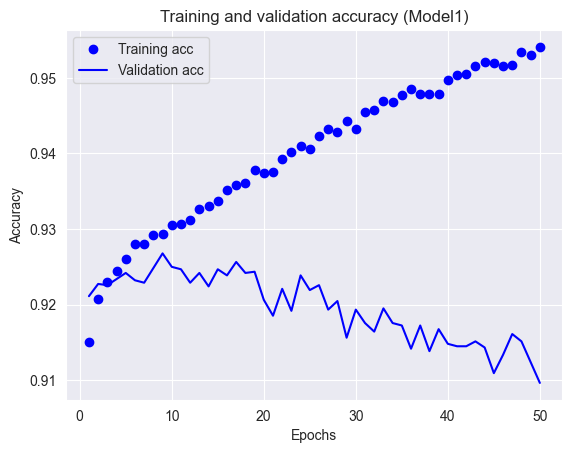

In [234]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Model1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model2 - Transfer Learning

In [235]:
X_pretrain_nw, X_finetune_nw, y_pretrain_nw, y_finetune_nw = train_test_split(X_train_nw, y_train_nw, test_size=0.5, random_state=42)

#### Model2 Initialization & Compilation

In [236]:
pretrain_model2 = Sequential([
    Input(shape=(X_pretrain_nw.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [237]:
pretrain_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [238]:
pretrain_history = pretrain_model2.fit(X_pretrain_nw, y_pretrain_nw, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 1s 1ms/step - loss: 0.2522 - accuracy: 0.9101 - val_loss: 0.1990 - val_accuracy: 0.9228
Epoch 2/50
387/387 [==============================] - 0s 1ms/step - loss: 0.2007 - accuracy: 0.9193 - val_loss: 0.1943 - val_accuracy: 0.9247
Epoch 3/50
387/387 [==============================] - 0s 978us/step - loss: 0.1928 - accuracy: 0.9228 - val_loss: 0.1901 - val_accuracy: 0.9247
Epoch 4/50
387/387 [==============================] - 0s 933us/step - loss: 0.1878 - accuracy: 0.9259 - val_loss: 0.1895 - val_accuracy: 0.9247
Epoch 5/50
387/387 [==============================] - 0s 978us/step - loss: 0.1836 - accuracy: 0.9256 - val_loss: 0.1903 - val_accuracy: 0.9260
Epoch 6/50
387/387 [==============================] - 0s 952us/step - loss: 0.1799 - accuracy: 0.9276 - val_loss: 0.1881 - val_accuracy: 0.9260
Epoch 7/50
387/387 [==============================] - 0s 994us/step - loss: 0.1763 - accuracy: 0.9294 - val_loss: 0.1892 - val_accuracy: 0.9

#### Pretraining Weights

In [239]:
pretrained_model2_weights = pretrain_model2.get_weights()

#### Finetune Model2

In [240]:
finetune_model2 = Sequential([
    Input(shape=(X_pretrain_nw.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [241]:
finetune_model2.set_weights(pretrained_model2_weights)

#### Compilation

In [242]:
finetune_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Εκπαίδευση

In [243]:
finetune_history = finetune_model2.fit(X_finetune_nw, y_finetune_nw, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
387/387 [==============================] - 1s 1ms/step - loss: 0.2929 - accuracy: 0.9074 - val_loss: 0.2553 - val_accuracy: 0.9089
Epoch 2/50
387/387 [==============================] - 0s 933us/step - loss: 0.2236 - accuracy: 0.9185 - val_loss: 0.2370 - val_accuracy: 0.9182
Epoch 3/50
387/387 [==============================] - 0s 1ms/step - loss: 0.1979 - accuracy: 0.9257 - val_loss: 0.2324 - val_accuracy: 0.9118
Epoch 4/50
387/387 [==============================] - 0s 965us/step - loss: 0.1837 - accuracy: 0.9314 - val_loss: 0.2316 - val_accuracy: 0.9137
Epoch 5/50
387/387 [==============================] - 0s 928us/step - loss: 0.1724 - accuracy: 0.9355 - val_loss: 0.2302 - val_accuracy: 0.9150
Epoch 6/50
387/387 [==============================] - 0s 926us/step - loss: 0.1632 - accuracy: 0.9376 - val_loss: 0.2261 - val_accuracy: 0.9121
Epoch 7/50
387/387 [==============================] - 0s 942us/step - loss: 0.1568 - accuracy: 0.9388 - val_loss: 0.2316 - val_accuracy: 0.9

#### Model2 Accuracy

In [249]:
loss, accuracy = finetune_model2.evaluate(X_test_nw, y_test_nw)
print(f'Model2 Accuracy: {accuracy}')

242/242 [==============================] - 0s 706us/step - loss: 0.4049 - accuracy: 0.9021
Transfer Learning Model Accuracy: 0.9021205306053162


#### Model2 Accuracy on Test Set

In [252]:
predictions2 = finetune_model2.predict(X_test_nw)
predicted_y2 = np.argmax(predictions2, axis=1)
accuracy = np.mean(predicted_y2 == y_test_nw)
print(f'Accuracy on test set: {accuracy}')

242/242 [==============================] - 0s 581us/step
Accuracy on test set: 0.9124644427204551


#### Classification Report

In [246]:
print(classification_report(y_test_nw, predicted_y2, zero_division=1))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95      7057
        True       1.00      0.00      0.00       677

    accuracy                           0.91      7734
   macro avg       0.96      0.50      0.48      7734
weighted avg       0.92      0.91      0.87      7734



#### Learning Rate

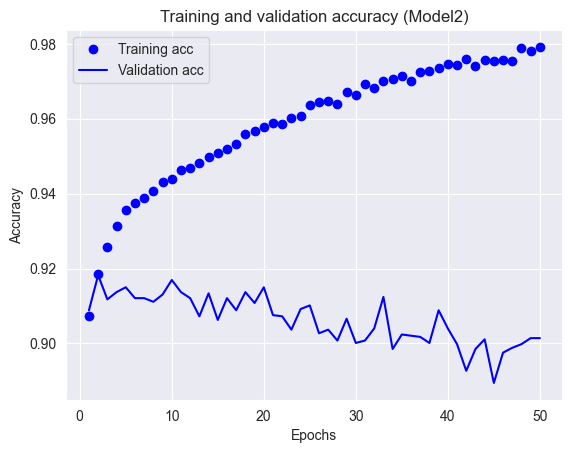

In [248]:
acc = finetune_history.history['accuracy']
val_acc = finetune_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Model2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()